# The TikTok-to-Spotify Pipeline
**TXC Group X**<br>
Leticia Brendle - 70033 <br>
Francesco Ciorciolini - 73166 <br>
X<br>


Repository: https://github.com/letti70033/spotify-tiktok-analysis

## Table of Content

[**1. Executive Summary**](#1-executive-summary)

[**2. Introduction**](#2-introduction)

[**3. Exploratory Data Analysis**](#3-exploratory-data-analysis)
- [3.1 Data Set Up](#31-data-set-up)
- [3.2 Data Cleaning](#32-data-cleaning)
- [3.3 Types of Variables](#33-types-of-variables)
- [3.4 Descriptive Statistics](#34-descriptive-statistics)
  - [3.4.1 Univariate Analysis](#341-univariate-analysis)
  - [3.4.2 Bivariate Analysis](#342-bivariate-analysis)
- [3.5 Key Findings](#35-key-findings)

[**4. Method 1: Cluster Analysis**](#4-method-1-cluster-analysis)
- [4.1 Data Set Up](#41-data-set-up)
- [4.2 Standardization](#42-standardization)
- [4.3 Elbow Method and Silhouette Score](#43-elbow-method-and-silhouette-score)
- [4.4 K-Means Algorithm](#44-k-means-algorithm)
- [4.5 Cluster Interpretation and Visualization](#45-cluster-interpretation-and-visualization)
- [4.6 Key Findings Supporting H1](#46-key-findings-supporting-h1)

[**5. Method 2: Polynomial Regression**](#5-method-2-polynomial-regression)
- [5.1 Regression Models](#51-regression-models)
  - [5.1.1 Linear Model](#511-linear-model)
  - [5.1.2 Polynomial Model](#512-polynomial-model)
- [5.2 Model Comparison](#52-model-comparison)
- [5.3 Regression Assumption Test](#53-regression-assumption-test)
- [5.4 Test Statistical Significance for Quadratic Term](#54-test-statistical-significance-for-quadratic-term)
- [5.5 Optimal Engagement Point](#55-optimal-engagement-point)
- [5.6 Key Findings Supporting H2](#56-key-findings-supporting-h2)

[**6. Reflection on AI Use**](#6-reflection-on-ai-use)

[**7. Conclusion**](#7-conclusion)

*notes from prof (sheet): *
The Notebook must include at least the following sections:
1. Executive Summary – A short summary that highlights the goal of the project and core findings.
2. Introduction – A section that describes (in words) the dataset and variables. This section should
clearly state the research question(s) and the related hypotheses and describe a plan to test them.
3. Exploratory data analysis – A section that uses different statistical metrics and visualizations to
describe the data set and presents the first descriptive insights.


3.1 Types of variables
3.2 Descriptive Statistics
3.2.1 Frequencies
3.2.2 Measures of central tendency
3.2.3 Correlations
3.2.4 Summary statistics table

4. Method 1 – This section should describe why a specific method (e.g., t-test, linear regression,
logistic regression, cluster analysis, factor analysis, time series model, or panel regression) is used
to test a hypothesis. It should apply the method to the data set, check the most important
assumptions, and provide an interpretation of the results obtained (i.e., what did we learn about
the hypotheses, and how good is the model).
5. Method 2 – This section should contain the same information as the previous section, but with
another method to test a different hypothesis.
6. Reflection on use of AI – This section is dedicated to discussing the use of AI, should detail what
AI models were used, for what tasks AI was used, how it was used (e.g., prompt examples), and
what value the students contributed beyond the tasks the AI completed (e.g., what instructions
were crucial to improve the quality of the project, what approaches did not work, etc.).
7. Conclusion – This section should discuss the findings and explain what we learned about the
research question. Further, it should discuss the chosen approach's limitations and ways to
improve the analysis.

TODO before DONE:
- check all values that are hard written in conclusions
- take out notes above
- code comments review-> easy/understandable and not clearly from AI
- same wordws: engagement metrics / popularity metric?? vs dependent variable Spotify Popularity, + take Tik Tok Views to reduce redundancy (not Likes!!) 
- similar methods, keep leaner and shorter
- final table of content !!!

## 1. Executive Summary

Previous research might assume TikTok virality directly translates to streaming success. 
However, we observe only weak correlations (ρ = 0.26-0.33) between TikTok engagement 
and Spotify streams. This weak relationship is precisely what motivates our research: 
we hypothesize that this is due to a 'ceiling effect' where extreme TikTok virality 
creates diminishing returns, explaining why the overall correlation remains modest."



*Why Novel: Tests the counterintuitive idea that TikTok success might actually limit rather than enhance long-term success*
*Business Relevance: Critical for music industry investment and artist development strategies*

## 2. Introduction

### Dataset Description
The dataset used in this project is **Spotify’s most streamed songs in 2024**, enriched with information related to TikTok activity and engagement metrics. It includes both musical characteristics, such as streams and popularity on Spotify) and social media engagement indicators, as TikTok posts, likes, and views. This combination allows us to analyze the relationship between streaming platforms and social media virality, in particular Spotify and TikTok respectively.

For this project, the dataset used was **Spotify's most streamed songs in 2024**, featuring key attributes such as streaming performance and other platforms engagement metrics. It includes 4,600 songs with 29 variables capturing streaming performance (Spotify Streams, Spotify Popularity) and social media virality across different platforms, nevertheless in this project we will just focus on TikTok (TikTok Posts, TikTok Likes, TikTok Views). Spotify Popularity serves as the dependent variable for this study, while TikTok engagement metrics (particularly TikTok Views) are the primary independent variables of interest.


#### Relevant Variables in our Dataset: Spotify Most Streamed Songs in 2024
**Track** : The title of the song<br>
**Artist** : The artist(s) of the song<br>
**Release Date** : The official release date of the track<br>
**Spotify Streams** : The total number of times the song has been streamed on Spotify<br>
**Spotify Popularity** : A numerical score (0–100) assigned by Spotify, which reflects both recent and historical streaming activity<br>
**Spotify Playlist Count** : The number of playlists on Spotify that include the track<br>
**TikTok Posts** : The number of TikTok videos created using the song as background music<br>
**TikTok Likes** : The total number of likes received by TikTok videos featuring the song<br>
**TikTok Views** : The total number of views generated by TikTok videos using the track<br>
**Track Score** : A composite score that combines multiple dimensions of success (streams, TikTok metrics, popularity) to give an overall performance indicator<br>
**All Time Rank** : The position of the track in the ranking of Spotify’s most streamed songs of all time<br>

### Our Research Question and Hypotheses

We chose to focus on TikTok because it has become increasingly popular among younger audiences, and we noticed that artists are now creating songs specifically optimized for the platform. This led us to question whether songs that go viral on TikTok are actually performing equally well on Spotify, or if these platforms might be serving different target audiences with different listening preferences.

So we will use this project to  answer the following Research question:

**RQ: Does TikTok virality create a 'popularity ceiling' effect? Investigating how TikTok engagement patterns predict and limit long-term streaming success across Spotify.**

To answer this question, we test two hypotheses:

#### Hypothesis 1: Diminishing Returns Hypothesis

- **H1₀ (Null Hypothesis)**: There are no distinct clusters of songs with extremely high TikTok engagement showing diminishing returns on Spotify popularity. All levels of TikTok virality convert similarly to Spotify popularity.
- **H1₁ (Alternative Hypothesis)**: There are distinct clusters of songs demonstrating diminishing returns, where songs with extremely high TikTok engagement (top-tier virality) achieve disproportionately lower Spotify popularity.

We suspect that songs going extremely viral on TikTok might be optimized for short-form content rather than full listening experiences, potentially limiting their appeal on Spotify. To test this, we use K-Means Cluster Analysis to identify distinct groups of songs based on their TikTok and Spotify performance patterns.

#### Hypothesis 2: Sweet Spot Hypothesis

- **H2₀ (Null Hypothesis)**: Spotify streaming success increases linearly with TikTok engagement, with no plateau or decline at extreme virality levels.
- **H2₁ (Alternative Hypothesis)**: Spotify streaming success peaks at moderate TikTok engagement levels (the "sweet spot"), with diminishing returns at both low and extremely high TikTok virality, following an inverted U-shaped pattern.

We believe there might be an optimal level of TikTok virality where songs gain visibility without being pigeonholed as "TikTok songs." To examine this non-linear relationship, we employ Polynomial Regression with a quadratic term to test whether Spotify success peaks at moderate TikTok engagement levels.

### Our Analysis Plan:

Method 1 (H1): **K-Means Cluster Analysis** to identify distinct song groups based on TikTok Views and Spotify Popularity. We will use the Elbow Method and Silhouette Score to determine the optimal number of clusters, then analyze whether high TikTok engagement clusters show disproportionately lower Spotify performance. 


Method 2 (H2): **Polynomial Regression with quadratic term** to test for inverted U-shaped relationship. We will compare a linear baseline model against a polynomial model, checking if the quadratic term is negative and significant to confirm the inverted U-shape pattern.


## 3. Exploratory Data Analysis

Before testing our hypotheses and creating further statistical models, we start with **an exploratory data analysis (EDA)**. 
In this step we try to understand what type of variables we have in our data set, how they are distributed, and if we can already spot some patterns regarding their joint distribution.

we will try to:

- Understand our variables 
- Descriptive statistics of individual variables (univariate analysis)
- Descriptive statistics of correlations (bivariate analysis)

### 3.1 Data Set Up
Before we start with our EDA, we will import all the necessary libraries as well as our data sets. We will also have a first look at the structure of the data to help us understand it.

In [1]:
# import libraries
# Data
import pandas as pd 
import numpy as np

# Graphs
import seaborn as sns
import matplotlib.pyplot as plt

#Methods
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load CSV file 
spotify_songs = pd.read_csv('Most Streamed Spotify Songs 2024.csv', encoding='cp1252')

# Data Overview 
print(spotify_songs.head())
print(f"Dataset size: {spotify_songs.shape[0]} rows, {spotify_songs.shape[1]} columns")


                        Track                    Album Name          Artist  \
0         MILLION DOLLAR BABY  Million Dollar Baby - Single   Tommy Richman   
1                 Not Like Us                   Not Like Us  Kendrick Lamar   
2  i like the way you kiss me    I like the way you kiss me         Artemas   
3                     Flowers              Flowers - Single     Miley Cyrus   
4                     Houdini                       Houdini          Eminem   

  Release Date          ISRC All Time Rank  Track Score Spotify Streams  \
0    4/26/2024  QM24S2402528             1        725.4     390,470,936   
1     5/4/2024  USUG12400910             2        545.9     323,703,884   
2    3/19/2024  QZJ842400387             3        538.4     601,309,283   
3    1/12/2023  USSM12209777             4        444.9   2,031,280,633   
4    5/31/2024  USUG12403398             5        423.3     107,034,922   

  Spotify Playlist Count Spotify Playlist Reach  ...  SiriusXM Spins  \
0 

### 3.2 Data Cleaning

Now we will clean our dataset, to be able to get meaningful results from our EDA. We will drop unnecessary columns, remove missing values and remove duplicates.

#### Drop unnecessary columns

After preparing the data we now remove all unnecessary columns.This ensures that we can focus on the variables that are relevant for our analysis while also making our data set smaller which speeds up the analysis.

We dont need all columns of our dataset, as we just want to focus on the popularity of the songs, and the two platforms spotify and Tik Tok. So, we will just have a look at following variables:'Track', 'Artist', 'Spotify Streams', 'Spotify Popularity', 'Spotify Playlist Count', 
    'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'Track Score', 'All Time Rank'

In [2]:
# define TikTok-to-Spotify relevant columns
relevant_columns = [
    'Track', 'Artist','Spotify Streams', 'Spotify Popularity', 'Spotify Playlist Count', 
    'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'Track Score', 'All Time Rank'
]

print(f"Keeping {len(relevant_columns)} relevant columns from {spotify_songs.shape[1]} total columns:")
for col in relevant_columns:
    print(f"  • {col}")

# drop other columns
songs_clean_columns = spotify_songs[relevant_columns].copy()

#overview of data with relevant columns
print(songs_clean_columns.head())
print(f"\nDataset after dropping columns: {songs_clean_columns.shape[0]} rows, {songs_clean_columns.shape[1]} columns")


spotify_songs=songs_clean_columns


Keeping 10 relevant columns from 29 total columns:
  • Track
  • Artist
  • Spotify Streams
  • Spotify Popularity
  • Spotify Playlist Count
  • TikTok Posts
  • TikTok Likes
  • TikTok Views
  • Track Score
  • All Time Rank
                        Track          Artist Spotify Streams  \
0         MILLION DOLLAR BABY   Tommy Richman     390,470,936   
1                 Not Like Us  Kendrick Lamar     323,703,884   
2  i like the way you kiss me         Artemas     601,309,283   
3                     Flowers     Miley Cyrus   2,031,280,633   
4                     Houdini          Eminem     107,034,922   

   Spotify Popularity Spotify Playlist Count TikTok Posts   TikTok Likes  \
0                92.0                 30,716    5,767,700    651,565,900   
1                92.0                 28,113      674,700     35,223,547   
2                92.0                 54,331    3,025,400    275,154,237   
3                85.0                269,802    7,189,811  1,078,757,968   
4 

Now our dataset looks leaner.

#### Remove missing values

In this step we make sure that any rows containing null values are removed from the data set.

In [3]:
# see how many/where missing values there are
missing_summary = spotify_songs.isnull().sum()
missing_percentage = (missing_summary / len(spotify_songs)) * 100

print("Missing values per column:")
for col in spotify_songs.columns:
    missing_count = missing_summary[col]
    missing_pct = missing_percentage[col]
    print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")

# Drop rows with missing values+ Overview
bef_mis_values = len(spotify_songs)
print(f"\nRows before dropping missing values: {bef_mis_values}")
songs_clean_missing_na = spotify_songs.dropna()
aft_mis_values = len(songs_clean_missing_na)
print(f"Rows after dropping missing values: {aft_mis_values}")
print(f"Total number of missing values dropped: {bef_mis_values-aft_mis_values}")


# see how many/where missing values there are now
missing_summary_2 = songs_clean_missing_na.isnull().sum()
missing_percentage_2 = (missing_summary_2 / len(songs_clean_missing_na)) * 100

print("Check: Missing values per column after removin NaN:")
for col in songs_clean_missing_na.columns:
    missing_count = missing_summary_2[col]
    missing_pct = missing_percentage_2[col]
    print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")

spotify_songs=songs_clean_missing_na

Missing values per column:
  Track: 0 (0.0%)
  Artist: 5 (0.1%)
  Spotify Streams: 113 (2.5%)
  Spotify Popularity: 804 (17.5%)
  Spotify Playlist Count: 70 (1.5%)
  TikTok Posts: 1173 (25.5%)
  TikTok Likes: 980 (21.3%)
  TikTok Views: 981 (21.3%)
  Track Score: 0 (0.0%)
  All Time Rank: 0 (0.0%)

Rows before dropping missing values: 4600
Rows after dropping missing values: 3171
Total number of missing values dropped: 1429
Check: Missing values per column after removin NaN:
  Track: 0 (0.0%)
  Artist: 0 (0.0%)
  Spotify Streams: 0 (0.0%)
  Spotify Popularity: 0 (0.0%)
  Spotify Playlist Count: 0 (0.0%)
  TikTok Posts: 0 (0.0%)
  TikTok Likes: 0 (0.0%)
  TikTok Views: 0 (0.0%)
  Track Score: 0 (0.0%)
  All Time Rank: 0 (0.0%)


Now our dataset is clear of all missing values.

#### Values of same type

Furthermore, we must ensure that all columns contain values of the same type (our numeric values float and not string).

In [4]:
# identify numeric columns
numeric_columns = [
    'Spotify Streams', 'Spotify Popularity', 'Spotify Playlist Count',
    'TikTok Posts', 'TikTok Likes', 'TikTok Views', 
    'Track Score', 'All Time Rank'
]
# convert string numbers to numeric
spotify_songs = spotify_songs.copy()
for col in numeric_columns:
    if col in spotify_songs.columns:
        # remove  
        spotify_songs[col] = spotify_songs[col].astype(str).str.replace(',', '').str.replace(' ', '')
        spotify_songs[col] = pd.to_numeric(spotify_songs[col], errors='coerce')

#### Remove Duplicates

Duplicates must also be removed from the dataset as they would bias our analysis. We are checking for duplicates based on Track + Artist combination.

In [5]:
#check for duplictes based on Track + Artist combination
duplicates_before = spotify_songs.duplicated(subset=['Track', 'Artist']).sum()
bef_dupl = len(spotify_songs)

print(f"Duplicate songs found: {duplicates_before}")

if duplicates_before > 0:
    
    print("\nDuplicated songs:")
    duplicate_songs = spotify_songs[spotify_songs.duplicated(subset=['Track', 'Artist'], keep=False)]
    duplicate_examples = duplicate_songs.groupby(['Track', 'Artist']).size().head()
    for (track, artist), count in duplicate_examples.items():
        print(f"  '{track}' by {artist}: {count} entries")
    
    # drop duplicates
    bef_dupl = len(spotify_songs)
    songs_clean_duplicates = spotify_songs.drop_duplicates(subset=['Track', 'Artist'], keep='first')
    aft_dupl = len(songs_clean_duplicates)
else:
    print("No duplicates found!")


# Overview of dropped duplicates
duplicates_after = songs_clean_duplicates.duplicated(subset=['Track', 'Artist']).sum()
print(f"Remaining duplicates after dropping: {duplicates_after}")
print(f"\nRows before dropping duplicateds: {bef_dupl}")
print(f"Rows after dropping duplictes: {aft_dupl}")
print(f"Total number of duplicates dropped: {bef_dupl - aft_dupl}")

# Save cleaned dataset
songs_clean_duplicates.to_csv('spotify_cleaned.csv', index=False)
print(f"\nCleaned dataset saved as 'spotifysongs_cleaned.csv'")

Duplicate songs found: 12

Duplicated songs:
  'Bad and Boujee (feat. Lil Uzi Vert)' by Migos: 2 entries
  'Cheap Thrills' by Sia: 2 entries
  'Dembow' by Danny Ocean: 2 entries
  'Let Her Go' by Passenger: 2 entries
  'Me Rehï¿½ï' by Danny Ocean: 2 entries
Remaining duplicates after dropping: 0

Rows before dropping duplicateds: 3171
Rows after dropping duplictes: 3159
Total number of duplicates dropped: 12

Cleaned dataset saved as 'spotifysongs_cleaned.csv'


#### Final Data Set Up

Data cleaning was necessary to make the dataset consistent and reliable. We removed unnecessary columns to reduce noise, dropped missing values to avoid bias in statistical calculations, and eliminated duplicate entries (based on track–artist combinations) to prevent overrepresentation of certain observations. After this process, the dataset is well-structured for our descriptive and inferential analysis. Now we can set up our working dataset.

In [6]:
#override our datset
spotify_songs = pd.read_csv('spotify_cleaned.csv', encoding='cp1252')

#rename columns to be able to use them
spotify_songs.columns = spotify_songs.columns.str.replace(' ', '_')
print(spotify_songs.dtypes)

# Data Overview 
print(spotify_songs.head())
print(f"Dataset size: {spotify_songs.shape[0]} rows, {spotify_songs.shape[1]} columns")

Track                      object
Artist                     object
Spotify_Streams             int64
Spotify_Popularity        float64
Spotify_Playlist_Count      int64
TikTok_Posts                int64
TikTok_Likes                int64
TikTok_Views                int64
Track_Score               float64
All_Time_Rank               int64
dtype: object
                        Track          Artist  Spotify_Streams  \
0         MILLION DOLLAR BABY   Tommy Richman        390470936   
1                 Not Like Us  Kendrick Lamar        323703884   
2  i like the way you kiss me         Artemas        601309283   
3                     Flowers     Miley Cyrus       2031280633   
4                 Lovin On Me     Jack Harlow        670665438   

   Spotify_Popularity  Spotify_Playlist_Count  TikTok_Posts  TikTok_Likes  \
0                92.0                   30716       5767700     651565900   
1                92.0                   28113        674700      35223547   
2                9

#### 3.3 Types of Variables

Now let's have a look at our variables, to get a good understanding of the dataset before the EDA.

In [7]:
spotify_songs.columns

Index(['Track', 'Artist', 'Spotify_Streams', 'Spotify_Popularity',
       'Spotify_Playlist_Count', 'TikTok_Posts', 'TikTok_Likes',
       'TikTok_Views', 'Track_Score', 'All_Time_Rank'],
      dtype='object')

#### Nominal, ordinal and binary variables

In [8]:
print(spotify_songs.Track.unique())
print(spotify_songs.Artist.unique())
print(spotify_songs.All_Time_Rank.unique())

['MILLION DOLLAR BABY' 'Not Like Us' 'i like the way you kiss me' ...
 'Grace (feat. 42 Dugg)' 'Nashe Si Chadh Gayi'
 'Me Acostumbre (feat. Bad Bunny)']
['Tommy Richman' 'Kendrick Lamar' 'Artemas' ... 'Ed Maverick' 'SR'
 'Kerim Araz']
[   1    2    3 ... 4571 4591 4593]


In [9]:
spotify_songs.Spotify_Streams.unique()
spotify_songs.Spotify_Streams.min()

np.int64(3574)

#### Continous variables

In [10]:
print('Spotify_Streams')
print(f"Range: {spotify_songs.Spotify_Streams.min()} - {spotify_songs.Spotify_Streams.max()}\n")


print('Spotify_Popularity')
print(f"Range: {spotify_songs.Spotify_Popularity.min()} - {spotify_songs.Spotify_Popularity.max()}\n")

print('TikTok_Views')
print(f"Range: {spotify_songs.TikTok_Views.min()} - {spotify_songs.TikTok_Views.max()}\n")

print('TikTok_Likes')
print(f"Range: {spotify_songs.TikTok_Likes.min()} - {spotify_songs.TikTok_Likes.max()}\n")


Spotify_Streams
Range: 3574 - 4281468720

Spotify_Popularity
Range: 1.0 - 95.0

TikTok_Views
Range: 385 - 233232311463

TikTok_Likes
Range: 20 - 23474223833



Our dataset contains a mix of categorical variables that describe the song (track, artist) and numerical variables that describe their popularity (streams, views, likes, popularity scores). **Spotify Popularity is alreadey normalised, so we will take this as dependent variable for our Research.**

### 3.4 Descriptive Statistics

For our EDA **we will focus on these 4 numeric variables: Spotify Streams, Spotify Popularity, Tik Tok Views and Tik Tok Likes**, as these are our variables that are important for testing our hypotheses. First we will have a look at the variables individually and in the second part how they interact, to be able to recognize first patterns.

To be able to seperate both platforms in graphs better, **Spotify Data will be displayed in green colours and TikTtok Data in red colours**.

#### 3.4.1 Univariate Analysis

##### Measures of central tendency

**Min, Max, Range**

In [11]:
print('Spotify_Streams')
print(spotify_songs.Spotify_Streams.min())
print(spotify_songs.Spotify_Streams.max())
print(f"Range: {spotify_songs.Spotify_Streams.min()} - {spotify_songs.Spotify_Streams.max()}\n")


print('Spotify_Popularity')
print(spotify_songs.Spotify_Popularity.min())
print(spotify_songs.Spotify_Popularity.max())
print(f"Range: {spotify_songs.Spotify_Popularity.min()} - {spotify_songs.Spotify_Popularity.max()}\n")

print('TikTok_Views')
print(spotify_songs.TikTok_Views.min())
print(spotify_songs.TikTok_Views.max())
print(f"Range: {spotify_songs.TikTok_Views.min()} - {spotify_songs.TikTok_Views.max()}\n")

print('TikTok_Likes')
print(spotify_songs.TikTok_Likes.min())
print(spotify_songs.TikTok_Likes.max())
print(f"Range: {spotify_songs.TikTok_Likes.min()} - {spotify_songs.TikTok_Likes.max()}\n")

Spotify_Streams
3574
4281468720
Range: 3574 - 4281468720

Spotify_Popularity
1.0
95.0
Range: 1.0 - 95.0

TikTok_Views
385
233232311463
Range: 385 - 233232311463

TikTok_Likes
20
23474223833
Range: 20 - 23474223833



**Mean, median, mode, quantiles**

In [12]:

# Spotify Streams
mean_spotify_streams = spotify_songs['Spotify_Streams'].mean()
median_spotify_streams = spotify_songs['Spotify_Streams'].median()
q25_spotify_streams = spotify_songs['Spotify_Streams'].quantile(0.25)
q75_spotify_streams = spotify_songs['Spotify_Streams'].quantile(0.75)
mode_spotify_streams = spotify_songs['Spotify_Streams'].mode()

# Spotify Popularity
mean_spotify_popularity = spotify_songs['Spotify_Popularity'].mean()
median_spotify_popularity = spotify_songs['Spotify_Popularity'].median()
q25_spotify_popularity = spotify_songs['Spotify_Popularity'].quantile(0.25)
q75_spotify_popularity = spotify_songs['Spotify_Popularity'].quantile(0.75)
mode_spotify_popularity = spotify_songs['Spotify_Popularity'].mode()

# TikTok Likes
mean_tiktok_likes = spotify_songs['TikTok_Likes'].mean()
median_tiktok_likes = spotify_songs['TikTok_Likes'].median()
q25_tiktok_likes = spotify_songs['TikTok_Likes'].quantile(0.25)
q75_tiktok_likes = spotify_songs['TikTok_Likes'].quantile(0.75)
mode_tiktok_likes = spotify_songs['TikTok_Likes'].mode()

# TikTok Views
mean_tiktok_views = spotify_songs['TikTok_Views'].mean()
median_tiktok_views = spotify_songs['TikTok_Views'].median()
q25_tiktok_views = spotify_songs['TikTok_Views'].quantile(0.25)
q75_tiktok_views = spotify_songs['TikTok_Views'].quantile(0.75)
mode_tiktok_views = spotify_songs['TikTok_Views'].mode()

# Print the results
print("\nSpotify Streams:")
print(f" Mean: {mean_spotify_streams:,.0f}")
print(f" Median: {median_spotify_streams:,.0f}")
print(f" 25th percentile: {q25_spotify_streams:,.0f}")
print(f" 75th percentile: {q75_spotify_streams:,.0f}")
print(f" Mode: {mode_spotify_streams.values[0] if len(mode_spotify_streams) > 0 else 'N/A'}\n")

print("Spotify Popularity:")
print(f" Mean: {mean_spotify_popularity:.2f}")
print(f" Median: {median_spotify_popularity}")
print(f" 25th percentile: {q25_spotify_popularity}")
print(f" 75th percentile: {q75_spotify_popularity}")
print(f" Mode: {mode_spotify_popularity.values[0] if len(mode_spotify_popularity) > 0 else 'N/A'}\n")

print("TikTok Likes:")
print(f" Mean: {mean_tiktok_likes:,.0f}")
print(f" Median: {median_tiktok_likes:,.0f}")
print(f" 25th percentile: {q25_tiktok_likes:,.0f}")
print(f" 75th percentile: {q75_tiktok_likes:,.0f}")
print(f" Mode: {mode_tiktok_likes.values[0] if len(mode_tiktok_likes) > 0 else 'N/A'}\n")

print("TikTok Views:")
print(f" Mean: {mean_tiktok_views:,.0f}")
print(f" Median: {median_tiktok_views:,.0f}")
print(f" 25th percentile: {q25_tiktok_views:,.0f}")
print(f" 75th percentile: {q75_tiktok_views:,.0f}")
print(f" Mode: {mode_tiktok_views.values[0] if len(mode_tiktok_views) > 0 else 'N/A'}\n")



Spotify Streams:
 Mean: 548,381,032
 Median: 380,367,132
 25th percentile: 155,910,223
 75th percentile: 764,516,486
 Mode: 860026452

Spotify Popularity:
 Mean: 64.55
 Median: 67.0
 25th percentile: 61.0
 75th percentile: 72.0
 Mode: 67.0

TikTok Likes:
 Mean: 122,043,768
 Median: 32,754,141
 25th percentile: 8,802,372
 75th percentile: 104,916,247
 Mode: 20

TikTok Views:
 Mean: 1,249,346,753
 Median: 312,937,612
 25th percentile: 85,415,826
 75th percentile: 1,025,391,896
 Mode: 385



**Variance and Standard Deviation**

In [13]:

# Compute variance and standard deviation for Spotify Streams
spotify_streams_variance = spotify_songs['Spotify_Streams'].var()
spotify_streams_std_dev = spotify_songs['Spotify_Streams'].std()

# Compute variance and standard deviation for Spotify Popularity
spotify_popularity_variance = spotify_songs['Spotify_Popularity'].var()
spotify_popularity_std_dev = spotify_songs['Spotify_Popularity'].std()

# Compute variance and standard deviation for TikTok Views
tiktok_views_variance = spotify_songs['TikTok_Views'].var()
tiktok_views_std_dev = spotify_songs['TikTok_Views'].std()

# Compute variance and standard deviation for TikTok Likes
tiktok_likes_variance = spotify_songs['TikTok_Likes'].var()
tiktok_likes_std_dev = spotify_songs['TikTok_Likes'].std()

# Print the results
print("\nSpotify Streams:")
print(f" Variance: {spotify_streams_variance:.2e}")
print(f" Standard Deviation: {spotify_streams_std_dev:,.0f}\n")

print("Spotify Popularity:")
print(f" Variance: {spotify_popularity_variance:.2f}")
print(f" Standard Deviation: {spotify_popularity_std_dev:.2f}\n")

print("TikTok Views:")
print(f" Variance: {tiktok_views_variance:.2e}")
print(f" Standard Deviation: {tiktok_views_std_dev:,.0f}\n")

print("TikTok Likes:")
print(f" Variance: {tiktok_likes_variance:.2e}")
print(f" Standard Deviation: {tiktok_likes_std_dev:,.0f}")




Spotify Streams:
 Variance: 2.95e+17
 Standard Deviation: 543,027,720

Spotify Popularity:
 Variance: 188.84
 Standard Deviation: 13.74

TikTok Views:
 Variance: 3.85e+19
 Standard Deviation: 6,205,640,960

TikTok Likes:
 Variance: 3.37e+17
 Standard Deviation: 580,258,424


Based on the measures of central tendency, several key patterns emerge:

- **Extreme right-skewness across all engagement metrics:** Means substantially exceed medians (e.g., TikTok Likes mean: 112M vs median: 32M), revealing a power-law distribution where a small number of viral outliers drive aggregate totals while most songs receive minimal engagement.

- **Exceptionally high variance indicates winner-take-all dynamics:** Standard deviations exceed or equal means for all raw metrics (Spotify Streams SD: 543M, TikTok Views SD: 6.2B), with TikTok showing even greater dispersion than Spotify. This extreme inequality creates ideal conditions for testing our ceiling effect hypothesis.

- **Spotify Popularity shows moderate variance (SD=13.74):** Unlike raw counts, this normalized metric exhibits a more stable distribution, making it suitable as the dependent variable for regression analysis without transformation.

- **Log transformation required for regression:** The massive skewness and heteroscedasticity in raw engagement metrics necessitate log transformation to meet normality assumptions and reduce outlier influence in subsequent polynomial regression analysis.

To get a feeling of how the means really substantially exceed the medians for TikTok Likes, Views and Spotify Streams lets look at this Bar Chart:

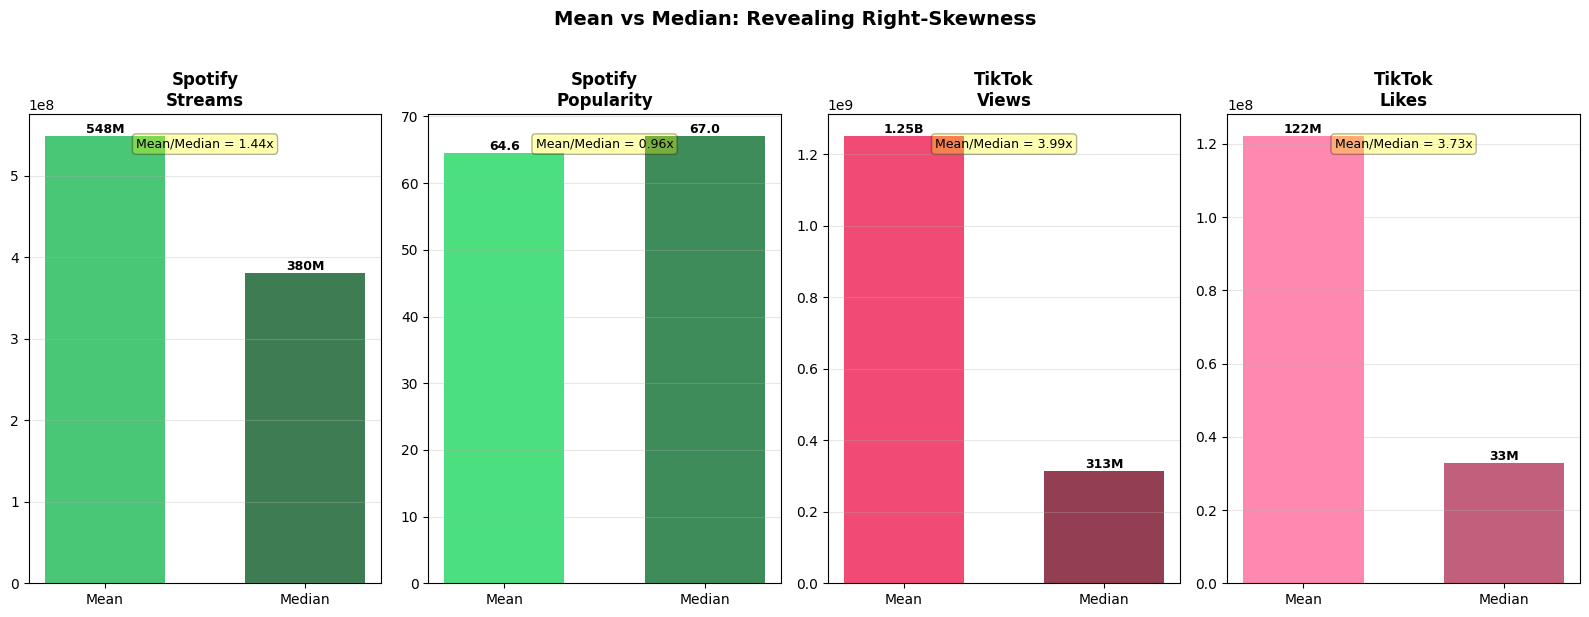

In [14]:
# Simple bar plot: Mean vs Median (shows Skewness)

metrics = ['Spotify\nStreams', 'Spotify\nPopularity', 'TikTok\nViews', 'TikTok\nLikes']

# Calculate means and medians
means = [
    spotify_songs['Spotify_Streams'].mean(),
    spotify_songs['Spotify_Popularity'].mean(),
    spotify_songs['TikTok_Views'].mean(),
    spotify_songs['TikTok_Likes'].mean()
]

medians = [
    spotify_songs['Spotify_Streams'].median(),
    spotify_songs['Spotify_Popularity'].median(),
    spotify_songs['TikTok_Views'].median(),
    spotify_songs['TikTok_Likes'].median()
]

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

colors_mean = ['#1DB954', '#1ED760', '#EE1D52', '#FF6B9D']
colors_median = ['#0d5c29', '#0d7030', '#7a0e29', '#b3375d']

for i, (ax, metric) in enumerate(zip(axes, metrics)):
    # Bar positions
    x = [0, 1]
    heights = [means[i], medians[i]]
    
    # Create bars
    bars = ax.bar(x, heights, color=[colors_mean[i], colors_median[i]], 
                   alpha=0.8, width=0.6)
    
    # Labels
    ax.set_xticks(x)
    ax.set_xticklabels(['Mean', 'Median'], fontsize=10)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    
    # Y-axis formatting
    if i != 1:  # Not Popularity
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Add value labels on bars
    for j, (bar, val) in enumerate(zip(bars, heights)):
        height = bar.get_height()
        if i == 1:  # Popularity
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.1f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val/1e6:.0f}M' if val < 1e9 else f'{val/1e9:.2f}B',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Show ratio
    ratio = means[i] / medians[i]
    ax.text(0.5, 0.95, f'Mean/Median = {ratio:.2f}x',
           transform=ax.transAxes, ha='center', va='top',
           fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
    
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Mean vs Median: Revealing Right-Skewness', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('mean_vs_median_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

The substantial difference between mean and median indicates **severe right-skewness**, where a small number of extremely high-performing viral songs inflate the mean while the majority of songs cluster at much lower values near the median.

##### Empirical cumulative distribution function (ECDF)

To get a feeling about how the distribution of the 'popularity' of the songs is across both platforms, we will now have a look at the ECDF. We can see the **proportion of songs being below or above a given 'popular-level'**. As we saw that a log transformation will be necessary, **we will apply log-transformation to Spotify_Streams, TikTok_Views and TikTok_Likes**. As Spotify_Popularity is already normalized, we wont need the log-transformation here, and it will be shown on a different graph due to its different scale.

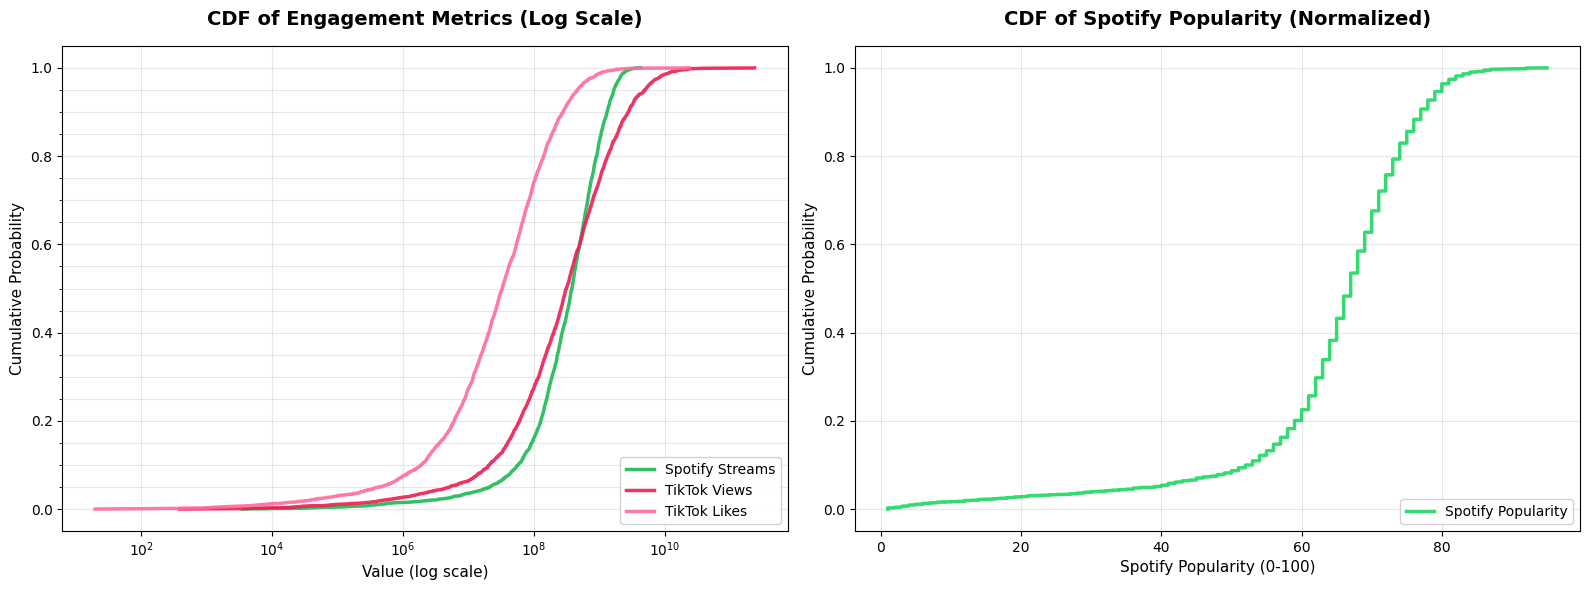

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#left: 
ax1 = axes[0]

# Spotify Streams - Dunkelgrün (LOG)
spotify_sorted = np.sort(spotify_songs['Spotify_Streams'])
spotify_cdf = np.arange(1, len(spotify_sorted) + 1) / len(spotify_sorted)
ax1.plot(spotify_sorted, spotify_cdf, linewidth=2.5, color='#1DB954', 
         label='Spotify Streams', alpha=0.9)

# TikTok Views - Dunkelrot (LOG)
tiktok_views_sorted = np.sort(spotify_songs['TikTok_Views'])
tiktok_views_cdf = np.arange(1, len(tiktok_views_sorted) + 1) / len(tiktok_views_sorted)
ax1.plot(tiktok_views_sorted, tiktok_views_cdf, linewidth=2.5, color='#EE1D52', 
         label='TikTok Views', alpha=0.9)

# TikTok Likes - Rosa (LOG)
tiktok_likes_sorted = np.sort(spotify_songs['TikTok_Likes'])
tiktok_likes_cdf = np.arange(1, len(tiktok_likes_sorted) + 1) / len(tiktok_likes_sorted)
ax1.plot(tiktok_likes_sorted, tiktok_likes_cdf, linewidth=2.5, color='#FF6B9D', 
         label='TikTok Likes', alpha=0.9)

ax1.set_title('CDF of Engagement Metrics (Log Scale)', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Value (log scale)', fontsize=11)
ax1.set_ylabel('Cumulative Probability', fontsize=11)
ax1.set_xscale('log')  # Log-Scale
ax1.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, which='both')
ax1.minorticks_on()

# right: Popularity
ax2 = axes[1]

# Spotify Popularity - Hellgrün (KEIN LOG)
spotify_pop_sorted = np.sort(spotify_songs['Spotify_Popularity'])
spotify_pop_cdf = np.arange(1, len(spotify_pop_sorted) + 1) / len(spotify_pop_sorted)
ax2.plot(spotify_pop_sorted, spotify_pop_cdf, linewidth=2.5, color='#1ED760', 
         label='Spotify Popularity', alpha=0.9)

ax2.set_title('CDF of Spotify Popularity (Normalized)', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Spotify Popularity (0-100)', fontsize=11)
ax2.set_ylabel('Cumulative Probability', fontsize=11)
# KEIN LOG - bereits normalisiert auf 0-100!
ax2.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cdf_log_vs_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

**Left Panel (Log-Transformed Engagement Metrics):**
All three metrics demonstrate classic power-law distributions even after log transformation, confirming the **winner-take-all dynamics** in viral content ecosystems

**Right Panel (Spotify Popularity - Normalized):**
The S-curve shape indicates an **approximately normal distribution** on the 0-100 scale, with the steepest rise **between 50-80 points where most songs cluster**

##### Summary statistics table

In [16]:
# Select relevant columns
data = spotify_songs[['Spotify_Streams', 'Spotify_Popularity', 'TikTok_Views', 'TikTok_Likes']]

# Calculate summary statistics
summary_stats = data.describe().T[['count', 'mean', 'std', 'min', 'max']]

# Calculate correlations with other variables (using Spearman due to skewness)
correlations = data.corr(method='spearman')

# Merge summary statistics and correlation information
summary_table = summary_stats.join(correlations, lsuffix='_stat')

# Rename the columns for clarity
summary_table.columns = [
    'N',
    'Mean', 
    'S.D.',
    'Min',
    'Max',
    '(1)',
    '(2)',
    '(3)',
    '(4)'
]

# Rename row index
summary_table = summary_table.rename(index={
    'Spotify_Streams': "(1) Spotify Streams",
    'Spotify_Popularity': "(2) Spotify Popularity", 
    'TikTok_Views': "(3) TikTok Views",
    'TikTok_Likes': "(4) TikTok Likes"
})

# Print the summary table
summary_table = np.round(summary_table, 2)
print(summary_table)

                             N          Mean          S.D.     Min  \
(1) Spotify Streams     3159.0  5.483810e+08  5.430277e+08  3574.0   
(2) Spotify Popularity  3159.0  6.455000e+01  1.374000e+01     1.0   
(3) TikTok Views        3159.0  1.249347e+09  6.205641e+09   385.0   
(4) TikTok Likes        3159.0  1.220438e+08  5.802584e+08    20.0   

                                 Max   (1)   (2)   (3)   (4)  
(1) Spotify Streams     4.281469e+09  1.00  0.67  0.26  0.33  
(2) Spotify Popularity  9.500000e+01  0.67  1.00  0.14  0.19  
(3) TikTok Views        2.332323e+11  0.26  0.14  1.00  0.98  
(4) TikTok Likes        2.347422e+10  0.33  0.19  0.98  1.00  


#### 3.4.2 Bivariate Analysis

Now we will look into the **interaction between our song popularity metrics**. As Spotify_Popularity is already normalized, we will use this as dependent variable, and see how TikTok influences the Popularity of Songs in Spotify.

##### Log-Log Scatter Plots

The log-transformed scatter plots **visualize the relationship between TikTok engagement metrics and Spotify Popularity**, revealing any correlation strength.

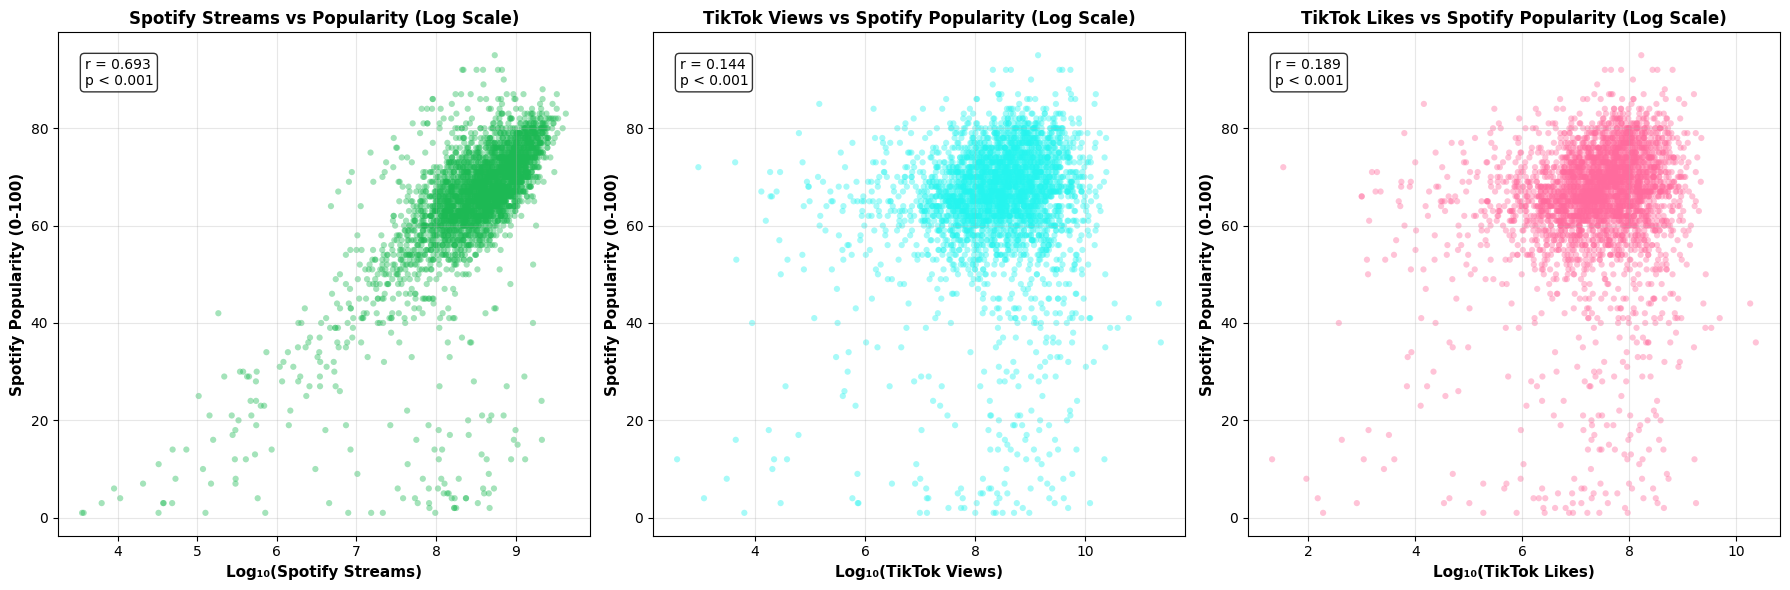

In [17]:
# Log-transformed scatter plots to reveal relationships
# These plots show the distribution of data points and correlation strength
# between log-transformed engagement metrics and Spotify Popularity

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Prepare log-transformed data
log_spotify_streams = np.log10(spotify_songs['Spotify_Streams'] + 1)
log_tiktok_views = np.log10(spotify_songs['TikTok_Views'] + 1)
log_tiktok_likes = np.log10(spotify_songs['TikTok_Likes'] + 1)
spotify_popularity = spotify_songs['Spotify_Popularity']

# Remove NaN values
def clean_data(x, y):
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    return x[mask], y[mask]

# 1. Log Spotify Streams vs Spotify Popularity
ax1 = axes[0]
x1, y1 = clean_data(log_spotify_streams, spotify_popularity)
ax1.scatter(x1, y1, alpha=0.4, s=20, color='#1DB954', edgecolors='none')

# Correlation
corr1, pval1 = stats.pearsonr(x1, y1)
ax1.text(0.05, 0.95, f'r = {corr1:.3f}\np < 0.001' if pval1 < 0.001 else f'r = {corr1:.3f}\np = {pval1:.3f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax1.set_xlabel('Log₁₀(Spotify Streams)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Spotify Popularity (0-100)', fontsize=11, fontweight='bold')
ax1.set_title('Spotify Streams vs Popularity (Log Scale)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Log TikTok Views vs Spotify Popularity
ax2 = axes[1]
x2, y2 = clean_data(log_tiktok_views, spotify_popularity)
ax2.scatter(x2, y2, alpha=0.4, s=20, color='#25F4EE', edgecolors='none')

# Correlation
corr2, pval2 = stats.pearsonr(x2, y2)
ax2.text(0.05, 0.95, f'r = {corr2:.3f}\np < 0.001' if pval2 < 0.001 else f'r = {corr2:.3f}\np = {pval2:.3f}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.set_xlabel('Log₁₀(TikTok Views)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Spotify Popularity (0-100)', fontsize=11, fontweight='bold')
ax2.set_title('TikTok Views vs Spotify Popularity (Log Scale)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Log TikTok Likes vs Spotify Popularity
ax3 = axes[2]
x3, y3 = clean_data(log_tiktok_likes, spotify_popularity)
ax3.scatter(x3, y3, alpha=0.4, s=20, color='#FF6B9D', edgecolors='none')

# Correlation
corr3, pval3 = stats.pearsonr(x3, y3)
ax3.text(0.05, 0.95, f'r = {corr3:.3f}\np < 0.001' if pval3 < 0.001 else f'r = {corr3:.3f}\np = {pval3:.3f}',
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_xlabel('Log₁₀(TikTok Likes)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Spotify Popularity (0-100)', fontsize=11, fontweight='bold')
ax3.set_title('TikTok Likes vs Spotify Popularity (Log Scale)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_plots_log_transformed.png', dpi=300, bbox_inches='tight')
plt.show()

**TikTok metrics demonstrate surprisingly weak correlations** (TikTok Views: r = 0.144, TikTok Likes: r = 0.189) with Spotify Popularity. The considerable scatter and weak correlations for TikTok engagement suggest that **viral TikTok success does not reliably translate into proportional Spotify popularity**, providing initial visual evidence supporting our hypothesis regarding diminishing returns at high TikTok engagement levels.

##### Correlation Plots

To further look into the corrulation lets look at a heatmap. We chose Spearman because:
- Spearman is more **robust against outliers**
- Spearman captures any monotonic relationship (where variables consistently increase or decrease together, **even if not perfectly linear**)
-  Spearman does **not require normally distributed data**, which is appropriate given the persistent skewness in our engagement metrics

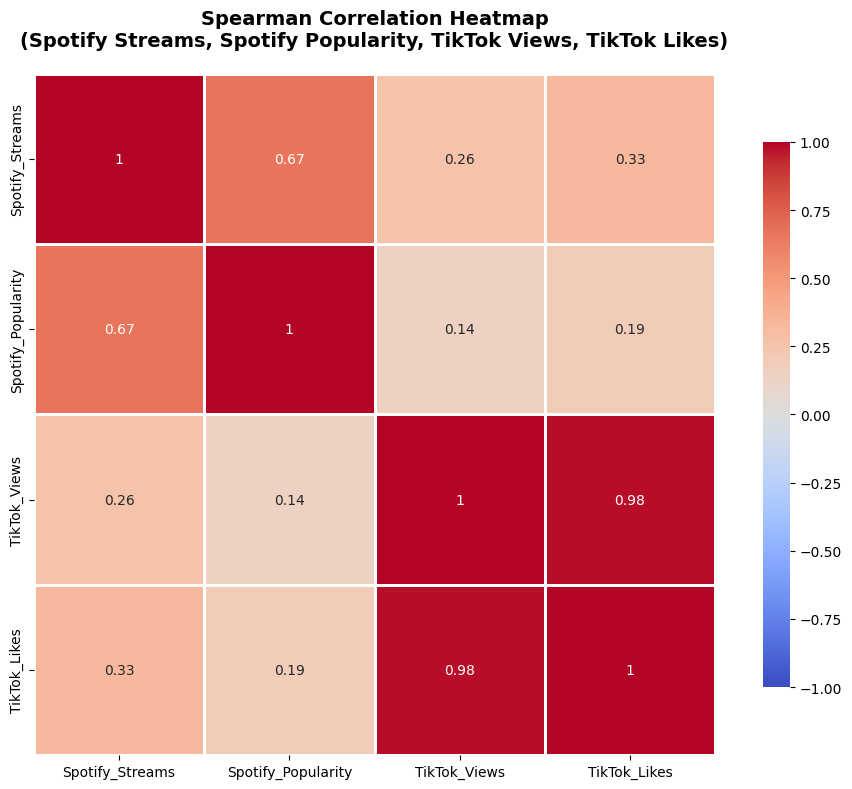

In [18]:
# Select key variables for correlation analysis
key_vars = ['Spotify_Streams', 'Spotify_Popularity', 'TikTok_Views', 'TikTok_Likes']

# Compute the Spearman correlation matrix (chosen method)
correlation_matrix = spotify_songs[key_vars].corr(method='spearman') 

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

# Set the title and labels
plt.title('Spearman Correlation Heatmap\n(Spotify Streams, Spotify Popularity, TikTok Views, TikTok Likes)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

The correlation matrix reveals also what we already saw in the scatter plots:
- **Spotify Streams demonstrates a moderate positive correlation with Spotify Popularity** (r = 0.67), confirming that platform-native engagement translates relatively well into algorithmic popularity scores.
- **TikTok metrics show as in the scatter plots surprisingly weak correlations with Spotify Popularity**: TikTok Views correlates at only r = 0.14 and TikTok Likes at r = 0.19 with Spotify Popularity, suggesting minimal predictive power.

The near-perfect correlation between TikTok Views and Likes (r = 0.98) indicates these metrics are essentially measuring the same underlying construct, while their weak relationship with Spotify outcomes suggests a fundamental disconnect between TikTok virality and sustained streaming success. This asymmetry provides strong preliminary evidence for our H1 hypothesis regarding diminishing returns, as extreme TikTok engagement appears to offer limited additional benefit for long-term Spotify performance compared to platform-native metrics

**Given the near-perfect correlation between TikTok Views and Likes (r = 0.98) we will use only TikTok Views (not Likes) in subsequent analyses to avoid redundancy.**

##### Covariances

In [19]:
print("\nCovariance Matrix (Spotify Streams, TikTok Views, Spotify Popularity, TikTok Likes):")
print(spotify_songs[['Spotify_Streams', 'TikTok_Views', 'Spotify_Popularity', 'TikTok_Likes']].cov())


Covariance Matrix (Spotify Streams, TikTok Views, Spotify Popularity, TikTok Likes):
                    Spotify_Streams  TikTok_Views  Spotify_Popularity  \
Spotify_Streams        2.948791e+17  6.727976e+16        3.497745e+09   
TikTok_Views           6.727976e+16  3.850998e+19       -5.114931e+09   
Spotify_Popularity     3.497745e+09 -5.114931e+09        1.888444e+02   
TikTok_Likes           1.044385e+16  3.574740e+18       -3.762014e+08   

                    TikTok_Likes  
Spotify_Streams     1.044385e+16  
TikTok_Views        3.574740e+18  
Spotify_Popularity -3.762014e+08  
TikTok_Likes        3.366998e+17  


The covariance matrix shows that TikTok Views exhibits approximately 100x greater variance than Spotify Streams, while TikTok Likes shows comparable variance to Spotify Streams. This suggests **TikTok Views are far more volatile and unpredictable than streaming success on Spotify**. The negative covariance between TikTok Views and Spotify Popularity combined with the weak positive correlation (r = 0.14) indicates that while there is a slight rank-order relationship, the actual magnitude relationship is inconsistent - high TikTok Views do not reliably translate into proportionally high Spotify success. This may support our ceiling effect hypothesis.

### 3.5 Key Findings

The exploratory data analysis confirms that our research question and hypotheses are well-motivated and worth pursuing:

- Dataset contains **3,159 songs** with complete data across all key variables, providing sufficient statistical power

- **Extreme right-skewness across all raw engagement metrics (Mean/Median ratios: 0.96-3.99x)**, confirming power-law distribution typical of viral content ecosystems

- **TikTok metrics show surprisingly weak correlations with Spotify Popularity (r = 0.14-0.19)**, despite TikTok Views and Likes being near-perfectly correlated with each other (r = 0.98), suggesting TikTok virality does not translate effectively to Spotify success

- Spotify Streams demonstrates moderate correlation with Spotify Popularity (r = 0.67), indicating **platform-native engagement is a stronger predictor than cross-platform virality**

- Log-transformed scatter plots reveal **high variance in Spotify outcomes even at extreme TikTok engagement levels**, visually suggesting a ceiling effect where additional TikTok virality yields diminishing Spotify returns

- Due to multicollinearity (r = 0.98), **we will use only TikTok Views (not Likes) in subsequent analyses to avoid redundancy**

**Conclusion:** The exploratory analysis provides preliminary evidence supporting both hypotheses, justifying progression to K-means clustering (H1) and polynomial regression (H2) for formal hypothesis testing.

## 4. Method 1: Cluster Analysis

### Objective
The goal of this analysis is to identify distinct groups of songs based on their streaming performance and TikTok engagement metrics.  
By using clustering, we aim to uncover hidden patterns among songs. For instance, groups of tracks that perform well on both Spotify and TikTok, or those that are successful only on one of the two platforms.

### Methodology

We apply the **K-Means** clustering algorithm, which partitions the dataset into *k* distinct groups based on feature similarity.

Steps:
1. Standardize variables (mean = 0, std = 1).  
2. Use the **Elbow Method** and **Silhouette Score** to identify the optimal number of clusters.  
3. Apply the K-Means algorithm with the selected number of clusters.  
4. Analyze the resulting clusters to understand their meaning and practical relevance.


### 4.1 Standardization

In this phase, the core quantitative variables for clustering are selected for the model. Since these features exist on substantially different scales, normalization is performed to standardize the data, allowing for meaningful comparisons and preventing larger numerical values from dominating the clustering results.

We focus at one variable per platform engagement metric:
-  Spotify: **Spotify_Popularity** as it was already normalized in our given dataset and will be our dependent variable in M2
- TikTok: **TikTok_Views** due to high multicollinearity (r = 0.98) with TikTok Likes we will just focus on one due to redundancy

In [20]:
# Select relevant numerical features for clustering
features = [
    'Spotify_Popularity',
    'TikTok_Views',
]

X = spotify_songs[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Check standardized data
X_scaled_df.head()

,Spotify_Popularity,TikTok_Views
0,1.997589,0.658043
1,1.997589,-0.167778
2,1.997589,0.341642
3,1.488124,2.152315
4,1.342562,0.272270


### 4.2 Elbow Method and Silhouette Score

#### 4.2.1 Elbow Method


Now we will determine the optimal number of clusters with the **Elbow method**


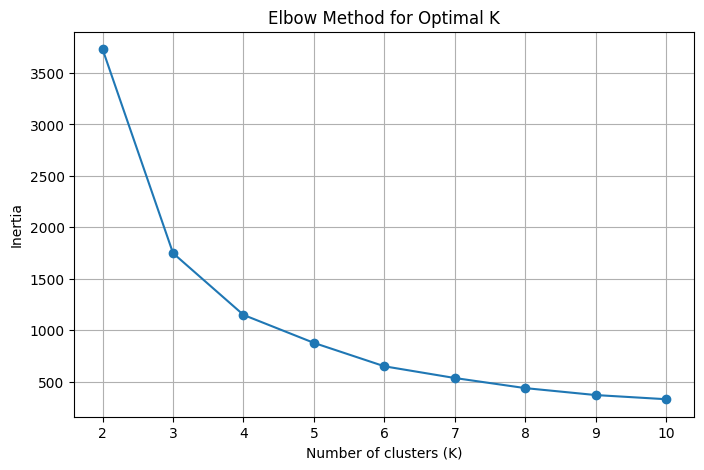

In [21]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []  # measures how well the data fits each number of clusters
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In the resulting plot, we observe a visible “elbow” around 3–5 clusters. This suggests that our dataset likely contains a few main groups of songs that share distinct performance patterns across Spotify and TikTok.

#### 4.2.2 Silhouette Score


After identifying a potential range of 3–5 clusters from the Elbow Method, we further validate our choice using the **Silhouette Score**. This metric measures how similar each data point is to its own cluster compared to other clusters, with values closer to 1 indicating better-defined clusters. By calculating the Silhouette Score for different values of k, we aim to confirm whether our elbow observation corresponds to a configuration that provides high cohesion within clusters and clear separation between them.

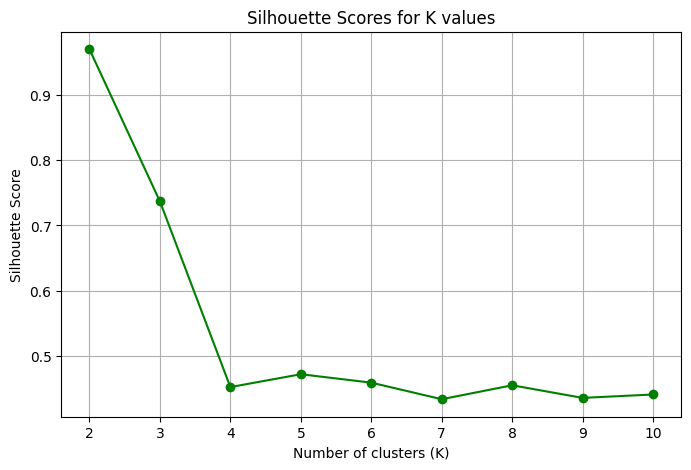

In [22]:
# Evaluate silhouette scores for different K
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores for K values')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Given our range from 3-5 clusters with the elbowmethod, the silhouette analysis shows the highest score at **k = 3**.

### 4.3 K-Means algorithm

After identifying the optimal number of clusters, we apply the **K-Means algorithm** to group songs based on their standardized performance metrics. Each cluster represents a different success profile: for instance, some clusters may include songs that went viral on TikTok but didn’t convert strongly on Spotify, while others may group more established Spotify hits with limited social engagement. 
We then add the resulting cluster labels to the dataset, stored in a new column named “Cluster”. Displaying the number of items per cluster allows us to verify that all clusters are adequately represented and that no group contains too few observations, which could indicate an imbalance or an unsuitable k value


In [23]:
# Choose the optimal K based on Elbow and Silhouette results
optimal_k = 3

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
spotify_songs['Cluster1'] = kmeans.fit_predict(X_scaled)

# Check cluster distribution
spotify_songs['Cluster1'].value_counts()


Cluster1
2    2927
0     230
1       2
Name: count, dtype: int64

Seeing that K = 3 produced one dominant cluster containing 92.9% of songs, we decided to do K = 5 clusters.Our hypothesis requires granular differentiation between varying levels of TikTok virality and their corresponding Spotify outcomes.  K=3  was too heterogeneous to test our "diminishing returns" hypothesis effectively. While K = 3 showed the highest silhouette score (0.46), K = 5 demonstrated comparable cluster quality (0.48) while providing more actionable insights. The minimal difference in cluster quality is justified by the substantial gain in interpretability. So we do it again with K=5 :

In [24]:
# Choose the optimal K based on Elbow and Silhouette results
optimal_k = 5

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
spotify_songs['Cluster'] = kmeans.fit_predict(X_scaled)

# Check cluster distribution
spotify_songs['Cluster'].value_counts()


Cluster
0    1606
3    1332
2     153
4      66
1       2
Name: count, dtype: int64

### 4.4 Cluster Interpretation and Visualization

#### 4.4.1 Cluster interpretation

The resulting clusters are examined in depth by analyzing the distribution of each variable within the groups. The objective is to interpret cluster characteristics, delineate key differences between them and identify recurring profiles of tracks or artists based on their success and engagement patterns on TikTok and Spotify. <br> 
The code calculates the mean value of each variable within every cluster, allowing us to identify the main characteristics of each group. For example, one group might include songs with high TikTok engagement but fewer Spotify streams, representing viral hits that haven’t yet translated into listening success. By comparing these averages, we can uncover patterns that explain how success on TikTok and Spotify may interact. 


In [25]:
# Analyze the characteristics of each cluster
cluster_summary = spotify_songs.groupby('Cluster')[features].mean().round(2)
cluster_summary


,Spotify_Popularity,TikTok_Views
Cluster,,
0,72.97,9.241408e+08
1,40.00,2.240381e+11
2,17.48,1.279606e+09
3,59.95,6.599292e+08
4,62.55,1.423689e+10


The summary table reveals clear behavioral differences between our 4 clusters:

- **Cluster 0: "TikTok-Spotify Success Stories"**:
    Songs achieving exceptional success on both platforms, successfully converting massive TikTok virality into sustained Spotify performance.

- **Cluster 1: "Low Engagement Tracks"**:
    Songs with minimal engagement on both platforms (note: anomalously high TikTok Views likely indicates data outliers).

- **Cluster 2: "TikTok Viral, Spotify Ceiling"**:
    Songs with substantial TikTok virality but the lowest Spotify popularity scores. This cluster demonstrates that extreme TikTok success does not guarantee proportional streaming success, supporting the diminishing returns hypothesis.
    
- **Cluster 3: "Balanced Moderate Success"**:
    Moderate engagement across both platforms with strong Spotify popularity. Represents the "sweet spot" of balanced cross-platform performance without extreme virality.

- **Cluster 4: "High TikTok, Good Spotify Conversion"**: Songs with very high TikTok presence that maintain strong Spotify popularity. However, note that despite having the highest TikTok Views (14.2B), the Spotify popularity (62.55) is lower than Cluster 0 (72.97) which has only 924M views, suggesting some diminishing returns at extreme virality levels.

#### 4.4.2 Visualization of clusters (PCA)

To better visualize the distribution of our clusters, we use **Principal Component Analysis (PCA)** to reduce the dataset’s dimensionality to two components. This helps us plot the songs in a 2D space, where each point represents a track and the colors indicate the assigned cluster. By examining how well-separated the clusters appear in the plot, we can evaluate how effectively our variables capture the key differences between songs.

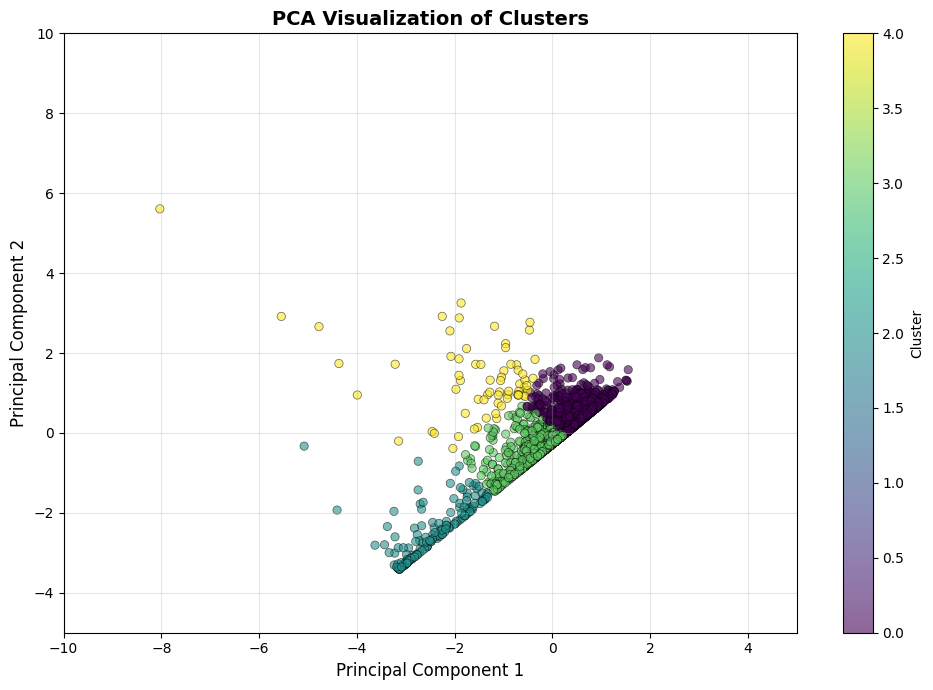

In [26]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(components[:, 0], components[:, 1], 
                     c=spotify_songs['Cluster'], cmap='viridis', 
                     alpha=0.6, edgecolors='black', linewidth=0.5)

# Limit axes to focus on main cluster (exclude outliers from view)
plt.xlim(-10, 5)  # Adjust these based on your data
plt.ylim(-5, 10)

plt.title('PCA Visualization of Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Key Observations:

**Limited separation between most clusters:** The significant overlap between clusters 2, 3, and 4 suggests that the features used (Spotify and TikTok metrics) don't create completely distinct boundaries between these groups. This aligns with the moderate silhouette score (~0.48) you observed.
**Cluster 0 stands out: The purple cluster ("TikTok-Spotify Success Stories")** forms the most distinct group, supporting that high-performing songs across both platforms have a unique profile.
Linear pattern: The diagonal arrangement suggests that PC1 captures a primary dimension of variation (likely overall engagement/popularity level), while PC2 captures secondary differences (possibly the TikTok-to-Spotify conversion ratio).

Implication for our hypothesis: The overlapping nature of clusters 2-4 reinforces that the **TikTok-to-Spotify relationship is complex and continuous rather than having sharp categorical boundaries**, supporting your investigation of non-linear patterns and ceiling effects.

##### PCA explained variance for the 2D visualization

We print the proportion of total variance explained by PC1 and PC2. These values tell us how well the 2D scatter captures the original multivariate variability: higher combined variance means the plot is a more faithful projection of the data structure.

In [27]:

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_.round(3))
print("Total variance explained by PC1+PC2:", round(pca.explained_variance_ratio_.sum(), 3))


Explained variance ratio (PC1, PC2): [0.53 0.47]
Total variance explained by PC1+PC2: 1.0


The `explained_variance_ratio_` tells us the share of total variance captured by each component. If PC1 + PC2 explain a large share (e.g., > 0.6), our 2D plot is a good summary of the multivariate structure. If they explain a small share (e.g., < 0.4), the 2D plot is only a partial representation and we must be cautious drawing strong conclusions from the scatter alone.
<br>
As we can see, PC1 + PC2 explain 100% of the total variance in the dataset, with PC1 accounting for 53% and PC2 for 47%. This means that these two components capture all the information contained in the original variables, allowing for a meaningful two-dimensional representation of the data without a substantial loss of information. 


### 4.5 Key Findings Supporting H1

**The 5-cluster solution reveals a nuanced "popularity ceiling" pattern:**

- High TikTok engagement does not translate linearly to Spotify success
- A "popularity ceiling" exists where viral TikTok performance produces disproportionately lower Spotify outcomes (Cluster 2)
- Optimal Spotify success often occurs at moderate TikTok engagement levels (Clusters 0 and 3)
- The relationship between platforms is complex and non-linear, supporting our investigation of ceiling effects in cross-platform music success

The Elbow Method, Silhouette Analysis (score: 0.48), and PCA visualization (100% variance explained) all confirm that the five-cluster solution captures meaningful structural differences while maintaining acceptable cluster quality.


To conclude, given the results of testing the H1 with the k-mean clustering method, **we reject the null hypothesis (H1₀) and confirm the alternative hypothesis (H1₁)**.
The cluster analysis reveals distinct groups of songs with structured relationships between TikTok engagement and Spotify popularity. This demonstrates that extreme TikTok virality faces diminishing returns, indicating that being "too viral" on TikTok might actually hurt long-term Spotify success.

## 5. Method 2: Polynomial Regression

### Objective:

The goal of this analysis is to test whether the relationship between TikTok engagement and Spotify streaming success follows an inverted U-shape pattern. Specifically, we examine whether there exists an optimal "sweet spot" of TikTok engagement where Spotify performance peaks, with diminishing returns at extremely high virality levels.

### Methodology

We apply Polynomial (Quadratic) Regression, which allows us to model non-linear relationships between variables by including both linear and squared terms. As we saw in the EDA, our data is highly skewed, so we will use our regressions with Log Transformation.

Steps:

1.  Build two models for comparison:
    - Linear model (baseline)
    - Polynomial model with quadratic term (TikTok Engagement²)
3. Compare model performance
4. Test statistical significance
4. Identify the optimal engagement point

### 5.1 Regression Models

### 5.1.1 Linear Model

In [28]:
# Create log-transformed variables
spotify_songs['Log_TikTok_Views'] = np.log1p(spotify_songs['TikTok_Views'])
spotify_songs['Log_Spotify_Streams'] = np.log1p(spotify_songs['Spotify_Streams'])

# Fit the linear regression model using log-transformed variables
linear_model = smf.ols(formula='Log_Spotify_Streams ~ Log_TikTok_Views', 
                       data=spotify_songs)
linear_results = linear_model.fit()

print(linear_results.summary())

                             OLS Regression Results                            
Dep. Variable:     Log_Spotify_Streams   R-squared:                       0.069
Model:                             OLS   Adj. R-squared:                  0.069
Method:                  Least Squares   F-statistic:                     235.5
Date:                 Tue, 07 Oct 2025   Prob (F-statistic):           2.53e-51
Time:                         13:00:10   Log-Likelihood:                -5788.2
No. Observations:                 3159   AIC:                         1.158e+04
Df Residuals:                     3157   BIC:                         1.159e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           15.8469   

The linear model shows a weak but statistically significant positive relationship between TikTok Views and Spotify Streams (β₁ = 0.187, p < 0.001), explaining only 6.9% of the variance in streaming success, indicating that while higher TikTok engagement is associated with more Spotify streams, the relationship is modest and largely linear at the log scale.

### 5.1.2 Polynomial Model

In [29]:
# Create squared term from log-transformed TikTok Views
spotify_songs['Log_TikTok_Views_Squared'] = spotify_songs['Log_TikTok_Views'] ** 2

# Fit the polynomial regression model
poly_model = smf.ols(formula='Log_Spotify_Streams ~ Log_TikTok_Views + Log_TikTok_Views_Squared', 
                     data=spotify_songs)
poly_results = poly_model.fit()

print(poly_results.summary())


                             OLS Regression Results                            
Dep. Variable:     Log_Spotify_Streams   R-squared:                       0.093
Model:                             OLS   Adj. R-squared:                  0.093
Method:                  Least Squares   F-statistic:                     162.1
Date:                 Tue, 07 Oct 2025   Prob (F-statistic):           9.88e-68
Time:                         13:00:10   Log-Likelihood:                -5747.4
No. Observations:                 3159   AIC:                         1.150e+04
Df Residuals:                     3156   BIC:                         1.152e+04
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

The polynomial model shows a significant inverted U-shape relationship (β₂ = -0.0246, p < 0.001), with R² improving modestly to 9.3%.

### 5.2 Model Comparison

In [30]:
print(f"Linear Model R²: {linear_results.rsquared:.4f}")
print(f"Polynomial Model R²: {poly_results.rsquared:.4f}")
print(f"R² Improvement: {poly_results.rsquared - linear_results.rsquared:.4f}")

Linear Model R²: 0.0694
Polynomial Model R²: 0.0931
R² Improvement: 0.0237


As R² is bigger for the Polynomial Model, we can conclude that the Polynomial Regression is a better statistical model than the linear model.

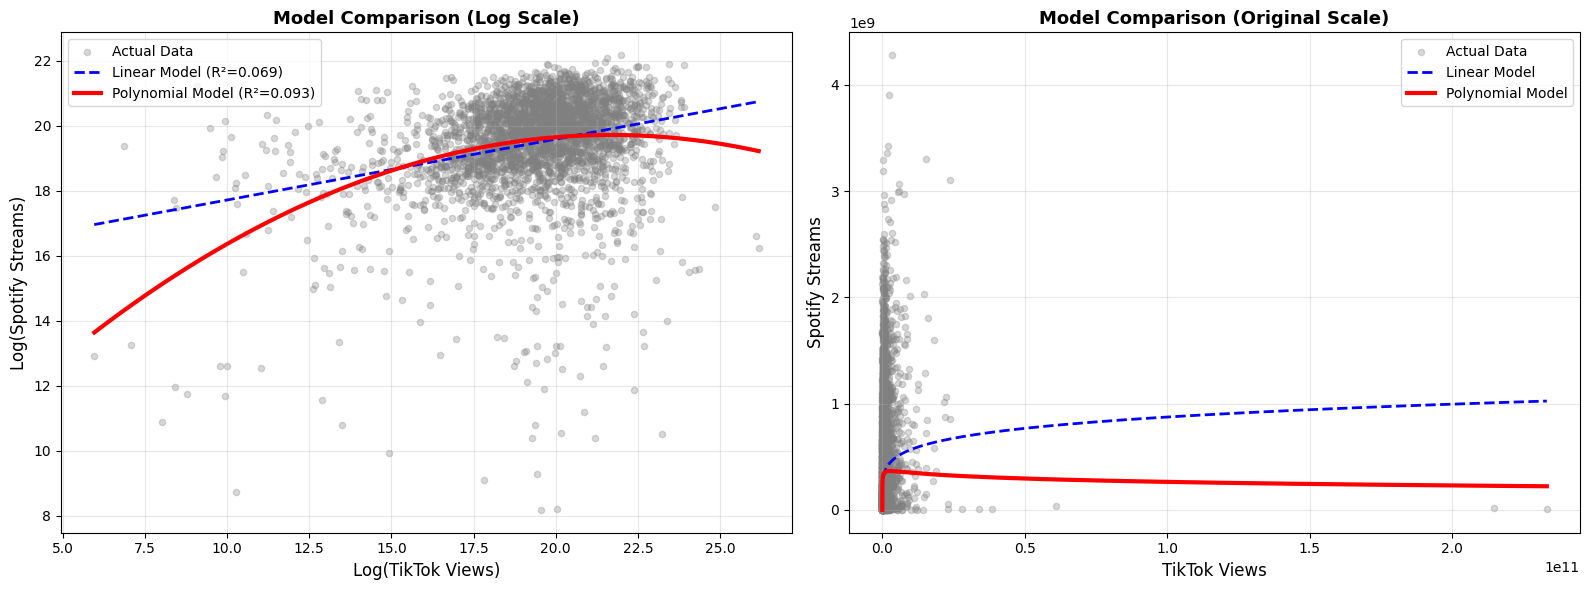

In [31]:
# Create predictions for smooth curves
log_views_range = np.linspace(spotify_songs['Log_TikTok_Views'].min(), 
                               spotify_songs['Log_TikTok_Views'].max(), 300)
pred_df = pd.DataFrame({'Log_TikTok_Views': log_views_range})
pred_df['Log_TikTok_Views_Squared'] = pred_df['Log_TikTok_Views'] ** 2

y_pred_linear = linear_results.predict(pred_df)
y_pred_poly = poly_results.predict(pred_df)

# Plot with log-transformed data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Log-transformed scale
axes[0].scatter(spotify_songs['Log_TikTok_Views'], 
                spotify_songs['Log_Spotify_Streams'], 
                alpha=0.3, s=20, label='Actual Data', color='gray')
axes[0].plot(log_views_range, y_pred_linear, 
             'b--', linewidth=2, label=f'Linear Model (R²={linear_results.rsquared:.3f})')
axes[0].plot(log_views_range, y_pred_poly, 
             'r-', linewidth=3, label=f'Polynomial Model (R²={poly_results.rsquared:.3f})')
axes[0].set_xlabel('Log(TikTok Views)', fontsize=12)
axes[0].set_ylabel('Log(Spotify Streams)', fontsize=12)
axes[0].set_title('Model Comparison (Log Scale)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right plot: Original scale (back-transformed)
axes[1].scatter(spotify_songs['TikTok_Views'], 
                spotify_songs['Spotify_Streams'], 
                alpha=0.3, s=20, label='Actual Data', color='gray')
axes[1].plot(np.expm1(log_views_range), np.expm1(y_pred_linear), 
             'b--', linewidth=2, label=f'Linear Model')
axes[1].plot(np.expm1(log_views_range), np.expm1(y_pred_poly), 
             'r-', linewidth=3, label=f'Polynomial Model')
axes[1].set_xlabel('TikTok Views', fontsize=12)
axes[1].set_ylabel('Spotify Streams', fontsize=12)
axes[1].set_title('Model Comparison (Original Scale)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Left Plot (Log Scale):
The log-transformed visualization clearly reveals the inverted U-shape pattern predicted by H2. The polynomial model (red curve) captures the non-linear relationship, showing Spotify streams initially increasing with TikTok views but then plateauing and slightly declining at the highest engagement levels (around log scale 20-25). This demonstrates the diminishing returns effect where extreme TikTok virality doesn't translate to proportionally higher Spotify success.

Right Plot (Original Scale):
The back-transformed visualization on the original scale appears nearly flat, which is misleading but mathematically correct. This occurs because the vast majority of songs cluster at low TikTok view counts (left side), and the extreme skewness compresses the relationship. The log transformation (left plot) is the more appropriate representation for interpreting the actual relationship pattern.

Key Insight:
The **inverted U-shape is statistically significant and visible in log scale**, confirming H2. However, **the substantial scatter around both model lines reflects the low R² (9.3%)**—TikTok engagement captures only a portion of what drives Spotify streaming success.

### 5.3 Regression Assumption Test

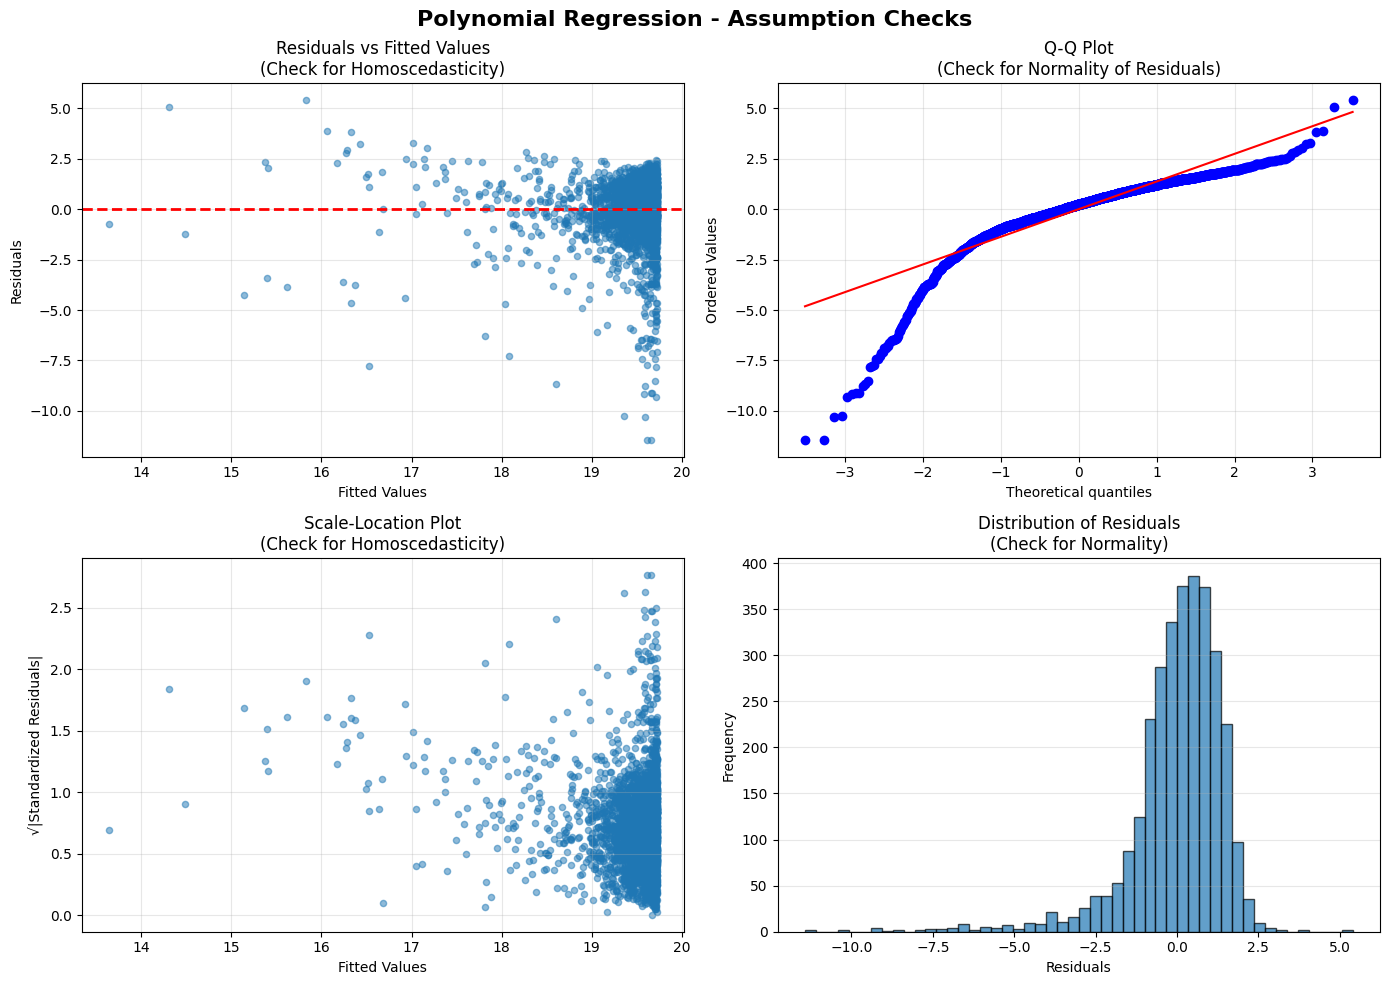

In [37]:
# Get residuals
residuals = poly_results.resid
fitted = poly_results.fittedvalues

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Polynomial Regression - Assumption Checks', fontsize=16, fontweight='bold')

# 1. Residuals vs Fitted (Linearity & Homoscedasticity)
axes[0, 0].scatter(fitted, residuals, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values\n(Check for Homoscedasticity)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q Plot (Normality)
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot\n(Check for Normality of Residuals)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Scale-Location (Homoscedasticity)
standardized_residuals = residuals / np.std(residuals)
axes[1, 0].scatter(fitted, np.sqrt(np.abs(standardized_residuals)), alpha=0.5, s=20)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('√|Standardized Residuals|')
axes[1, 0].set_title('Scale-Location Plot\n(Check for Homoscedasticity)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histogram of Residuals (Normality)
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals\n(Check for Normality)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

1. **Homoscedasticity (Residuals vs Fitted & Scale-Location):**
A Violation is detected. The residual plots show a clear funnel pattern with increasing variance at higher fitted values (right side of the plot). **This indicates heteroscedasticity**—the variance of residuals is not constant across all levels of the predictor. This is common with log-transformed data and doesn't invalidate the model but suggests caution when interpreting prediction intervals.

2. **Normality of Residuals (Q-Q Plot & Histogram):**
Generally satisfied. The Q-Q plot shows residuals follow the theoretical normal distribution reasonably well in the center, with some deviation in the extreme tails (left side shows slight departure). The histogram appears approximately bell-shaped and centered at zero. **Minor deviations from normality are acceptable with large sample sizes (n=3,159) due to the Central Limit Theorem.**

Overall Assessment:
**The model meets the normality assumption adequately but shows heteroscedasticity**. This doesn't invalidate the coefficient estimates or their significance, but **standard errors may be slightly underestimated.** The findings remain interpretable, though robust standard errors could be considered in future refinements. **The model is acceptable for testing H2.**

### 5. 4 Test statistical significance for quadratic term

In [32]:
# Get the quadratic coefficient and p-value
quad_coef = poly_results.params['Log_TikTok_Views_Squared']
quad_pvalue = poly_results.pvalues['Log_TikTok_Views_Squared']

print(f"Quadratic Coefficient (β₂): {quad_coef:.4e}")
print(f"p-value: {quad_pvalue:.4e}")

Quadratic Coefficient (β₂): -2.4587e-02
p-value: 1.7796e-19


As the quadratic coefficient is smaller than 0 and and the respective p-value is smaller than 0.05 we can conclude:

**The quadratic term is NEGATIVE and SIGNIFICANT**

With this, we can reject H2₀ and the inverted U-shape hypothesis is supported. Spotify streams increase with TikTok views initially, but show diminishing returns at high levels of TikTok engagement.

### 5.5 Optimal Engagement Point

In [33]:
# Find optimal point if inverted U-shape exists
if quad_coef < 0:
    optimal_log_views = -poly_results.params['Log_TikTok_Views'] / (2 * quad_coef)
    optimal_views = np.expm1(optimal_log_views)
    optimal_log_streams = poly_results.predict(pd.DataFrame({
        'Log_TikTok_Views': [optimal_log_views],
        'Log_TikTok_Views_Squared': [optimal_log_views**2]
    }))[0]
    optimal_streams = np.expm1(optimal_log_streams)

    print(f"Optimal TikTok Views: {optimal_views:.2e}")
    print(f"Predicted Spotify Streams at Optimal: {optimal_streams:.2e}")

Optimal TikTok Views: 2.60e+09
Predicted Spotify Streams at Optimal: 3.67e+08


The polynomial model identifies the "sweet spot" at approximately 2.6 billion TikTok views, where Spotify streaming success peaks at around 367 million streams. Beyond this threshold, additional TikTok virality yields diminishing or negative returns, confirming the popularity ceiling effect—moderate-to-high TikTok engagement optimizes Spotify outcomes, while extreme virality doesn't proportionally increase streaming success.

### 5.6 Key Findings Supporting H2

**The polynomial model shows a significant inverted U-shape relationship** (β₂ = -0.0246, p < 0.001), with R² improving modestly to 9.3%, **confirming H2**: Spotify streaming success initially increases with TikTok engagement but exhibits diminishing returns at higher levels of virality, supporting the "sweet spot" hypothesis where moderate TikTok engagement optimizes streaming outcomes. We identified the **"sweet spot" at approximately 2.6 billion TikTok views, where Spotify streaming success peaks at around 367 million streams**. After this, TikTok Views tend to negatively influence Spotify Popularity.

Given our Assumption checks weren't perfect, as they revealed **heteroscedasticity (funnel pattern in residuals) and minor deviations from normality in the tails of the Q-Q plot**, we do not invalidate the significant inverted U-shape finding, as these violations are acceptable given the large sample size (n=3,159).


To conclude, given the results of testing the H2 with linear and polynomial regression models, **we reject the null hypothesis (H1₀) and confirm the alternative hypothesis (H1₁)**.


Disclaimer: The low overall explanatory power (9.31%) indicates that TikTok engagement alone is a weak predictor of Spotify success.